In [2]:

import numpy as np
import pandas as pd
from pandas import DataFrame  as DF
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.model_selection import KFold
from functools import partial
import optuna
from xfeat import SelectCategorical, LabelEncoder, Pipeline,ConcatCombination, SelectNumerical,ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [3]:
df = pd.read_csv("input/OnlineNewsPopularity.csv")
df

In [6]:
#列名取得
col_lst = df.columns
# col_lst

In [ ]:
#欠損値チェック

check_null = df.isnull().any().values.tolist()
check_null = [[col_lst[i],check_null[i]] for i in range(len(col_lst))]
check_null

In [27]:
#列ごとに統計量をチェック

n = 9
# print(df[col_lst[n]].describe())
print(df["shares"].describe())


count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


In [21]:
coef_map_df = df.loc[:, "n_tokens_title":]
target_df = df["shares"]
data_df = df.loc[0:, "n_tokens_title":"abs_title_sentiment_polarity"]

C:\Users\kyotn\anaconda3\envs\data-science\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

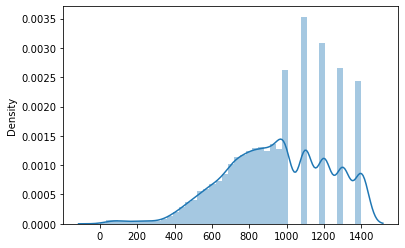

In [38]:
# y = target_df.values
y = target_df[target_df <= 1400 ].values
sns.distplot(y)

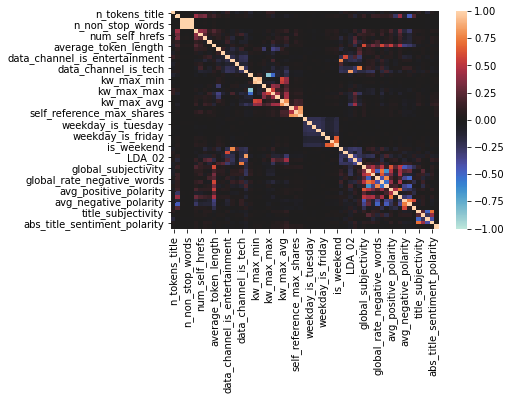

In [26]:
sns.heatmap(coef_map_df.corr(), vmax=1, vmin=-1, center=0)
corr_df = coef_map_df.corr()
corr_df.to_clipboard()


In [24]:
coef_map_df

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


In [43]:
# dlth = data less&equal than half
# dmth = data more than half

dlth = coef_map_df[coef_map_df["shares"] <= 1400]
dmth = coef_map_df[coef_map_df["shares"] > 1400]

# dlt75 = data less&equal than 75%, more than 50%
# dmt75 = data more than 75%

dlt75 = dmth[dmth["shares"] <= 2800]
dmt75 = dmth[dmth["shares"] > 2800]

print(len(dlth)+len(dmth))

 ### 25、50、75％で分割して2値分類の形にしてみる (test1) 

In [68]:
# t1d = test1_data
# tl = target_list
#25, 50, 75 =  946, 140, 2800
t1d = coef_map_df.copy()
tl = []
for i in range(len(t1d)):
    if t1d.loc[i, "shares"] <= 1400:
        tl.append(0)

    if t1d.loc[i, "shares"] > 1400:
        tl.append(1)

t1d["target"] = tl

In [ ]:
# corr_df = t1d.corr()
# corr_df.to_clipboard()
t1d

In [69]:
_input = t1d.drop("shares", axis=1)
_input

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,target
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1
39640,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1
39641,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1
39642,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,0


### LightGBMで変数選択

In [70]:
# LightGBMのパラメータを設定する
lgbm_params = {
    "objective": "binary",
    "metric": "binary_error",
}
fit_kwargs = {
    "num_boost_round": 10,
}

# 特徴量選択器を作成する
selector = GBDTFeatureSelector(
    target_col="target",
    threshold=0.5,
    lgbm_params=lgbm_params,
    lgbm_fit_kwargs=fit_kwargs,
)

selected_df = selector.fit_transform(_input)
print("Selected columns:", selector._selected_cols)

[LightGBM] [Info] Number of positive: 19562, number of negative: 20082
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8258
[LightGBM] [Info] Number of data points in the train set: 39644, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493442 -> initscore=-0.026235
[LightGBM] [Info] Start training from score -0.026235
Selected columns: ['is_weekend', 'self_reference_min_shares', 'kw_avg_avg', 'kw_max_avg', 'LDA_00', 'data_channel_is_socmed', 'kw_min_avg', 'n_unique_tokens', 'data_channel_is_entertainment', 'data_channel_is_tech', 'kw_avg_min', 'n_non_stop_unique_tokens', 'kw_max_max', 'n_tokens_content', 'self_reference_avg_sharess', 'LDA_02', 'min_positive_polarity', 'num_imgs', 'LDA_01', 'kw_min_max', 'kw_avg_max', 'num_hrefs', 'LDA_04', 'global_subjectivity', 'self_reference_max_shares', 'num_self_hrefs', 'nu

In [74]:
import lightgbm as lgb

LGBM_PARAMS = {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
}


def objective(df, selector, trial):
    selector.set_trial(trial)
    selector.fit(df)
    input_cols = selector.get_selected_cols()

    # Hyper Parameter Tuning するパラメータと範囲を設定する
    lgbm_params = {
        'num_leaves': trial.suggest_int("num_leaves", 3, 20),
        'max_depth': trial.suggest_int("max_depth", 3, 20),
    }
    lgbm_params.update(LGBM_PARAMS)

    # Evaluate with selected columns
    train_set = lgb.Dataset(_input[input_cols], label=_input["target"])
    scores = lgb.cv(lgbm_params, train_set, num_boost_round=100, stratified=False, seed=1)
    
    binary_error_score = scores['binary_error-mean'][-1]
    return 1 - binary_error_score


# 特徴量探索のための説明変数を設定する
# encoded_train_df は、No.7で作成したDataFrameと同じ
input_cols = list(_input.columns)
input_cols.remove('target')


# 特徴量探索器を作成する
selector = GBDTFeatureExplorer(
    input_cols=input_cols,
    target_col="target",
    fit_once=True,
    threshold_range=(0.2, 0.5),
    lgbm_params=LGBM_PARAMS,
)

# Hyper Parameter Tuning を行う
study = optuna.create_study(direction="minimize")
study.optimize(partial(objective, _input, selector), n_trials=100)

# 選択された特徴量を確認する
selector.from_trial(study.best_trial)
print("Selected columns:", selector.get_selected_cols())

[I 2021-07-10 18:03:47,904] A new study created in memory with name: no-name-d54b72b0-c506-4076-bc7c-57eb2c21265b
[I 2021-07-10 18:03:49,937] Trial 0 finished with value: 0.6463420787083753 and parameters: {'GBDTFeatureSelector.threshold': 0.2594814891345035, 'num_leaves': 11, 'max_depth': 3}. Best is trial 0 with value: 0.6463420787083753.
[I 2021-07-10 18:03:51,118] Trial 1 finished with value: 0.6438698284561049 and parameters: {'GBDTFeatureSelector.threshold': 0.2483409803192202, 'num_leaves': 5, 'max_depth': 16}. Best is trial 1 with value: 0.6438698284561049.
[I 2021-07-10 18:03:52,579] Trial 2 finished with value: 0.6571644803229062 and parameters: {'GBDTFeatureSelector.threshold': 0.3675029714178025, 'num_leaves': 8, 'max_depth': 19}. Best is trial 1 with value: 0.6438698284561049.
[I 2021-07-10 18:03:54,486] Trial 3 finished with value: 0.6599394550958627 and parameters: {'GBDTFeatureSelector.threshold': 0.4691215621338446, 'num_leaves': 15, 'max_depth': 9}. Best is trial 1 wi

Selected columns: ['LDA_00', 'kw_avg_avg', 'LDA_02', 'kw_max_avg', 'n_unique_tokens', 'self_reference_min_shares', 'n_tokens_content', 'n_non_stop_unique_tokens', 'kw_avg_min', 'kw_avg_max', 'LDA_03', 'average_token_length', 'LDA_01']


 imprtant_variable? :
 Selected columns: ['LDA_00', 'kw_avg_avg', 'LDA_02', 'kw_max_avg', 'n_unique_tokens',
                    'self_reference_min_shares', 'n_tokens_content', 'n_non_stop_unique_tokens',
                    'kw_avg_min', 'kw_avg_max', 'LDA_03', 'average_token_length', 'LDA_01']

In [11]:
lst = []
for i in range(len(df)):
    if df.loc[i, " weekday_is_monday"]:
        lst.append(0)

    if df.loc[i, " weekday_is_tuesday"]:
        lst.append(1)

    if df.loc[i, " weekday_is_wednesday"]:
        lst.append(2)

    if df.loc[i, " weekday_is_thursday"]:
        lst.append(3)

    if df.loc[i, " weekday_is_friday"]:
        lst.append(4)

    if df.loc[i, " weekday_is_saturday"]:
        lst.append(5)

    if df.loc[i, " weekday_is_sunday"]:
        lst.append(6)

df["weekday"] = lst

       


In [14]:
pt_temp = pd.pivot_table(df, index=df["weekday"], columns=df[" shares"],
                             values=" shares", aggfunc="count")

In [21]:
out = pt_temp.fillna(0)


In [24]:
out.to_csv("pivot.csv")

In [22]:
out

shares,1,4,5,8,22,23,28,35,36,41,...,284700,298400,306100,310800,441000,617900,652900,663600,690400,843300
weekday,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
